## Importing libraries

In [71]:
# Standard library imports
import os
import sys
import json
import random

# Third-party library imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Google Colab specific imports
from google.colab import drive

# Set the working directory
DIR_DATA = '/content/'
os.chdir(DIR_DATA)


# Datasets

In [72]:
class CIFAR100Dataset(Dataset):
    def __init__(self, root, split='train', transform=None, sharding=None, K=10, Nc=2):
        """
        CIFAR-100 Dataset with IID and non-IID sharding.

        Args:
        - root (str): Directory to store the dataset.
        - split (str): 'train' or 'test'.
        - transform (callable): Transformations applied to the images.
        - sharding (str): 'iid' or 'niid'.
        - K (int): Number of clients for the sharding.
        - Nc (int): Number of classes per client (used for non-iid sharding).
        """
        self.root = root
        self.split = split
        self.transform = transform
        self.sharding = sharding
        self.K = K
        self.Nc = Nc

        # Default transformations if none are provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        dataset = datasets.CIFAR100(
            root=self.root,
            train=(self.split == 'train'),
            download=True
        )

        self.data = pd.DataFrame({
            "image": [dataset[i][0] for i in range(len(dataset))],
            "label": [dataset[i][1] for i in range(len(dataset))]
        })

        if self.split == 'train' and self.sharding:
            self.data = self._apply_sharding()

    def _apply_sharding(self):
        """Apply IID or non-IID sharding to the training data."""
        if self.sharding == 'iid':
            return self._iid_sharding()
        elif self.sharding == 'niid':
            return self._non_iid_sharding()
        else:
            raise ValueError("Sharding must be 'iid' or 'niid'.")

    def _iid_sharding(self):
        """Split data IID: uniformly distribute samples across K clients."""
        data_split = []
        indices = self.data.index.tolist()
        random.shuffle(indices)

        # Split indices equally among K clients
        client_indices = [indices[i::self.K] for i in range(self.K)]

        for client_id, idxs in enumerate(client_indices):
            client_data = self.data.loc[idxs].copy()
            client_data['client_id'] = client_id
            data_split.append(client_data)

        return pd.concat(data_split, ignore_index=True)

    def _non_iid_sharding(self):
        """Split data non-IID: assign Nc classes per client."""
        data_split = []
        unique_classes = self.data['label'].unique()
        random.shuffle(unique_classes)

        # Divide classes into groups of Nc
        class_groups = [unique_classes[i:i + self.Nc] for i in range(0, len(unique_classes), self.Nc)]
        class_groups = class_groups[:self.K]  # Limit to K clients

        for client_id, class_group in enumerate(class_groups):
            client_data = self.data[self.data['label'].isin(class_group)].copy()
            client_data['client_id'] = client_id

            # Ensure approximately equal samples per client
            client_data = client_data.sample(n=len(self.data) // self.K, replace=True, random_state=42)
            data_split.append(client_data)

        return pd.concat(data_split, ignore_index=True)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image, label = row['image'], row['label']

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)


In [69]:
class ShakespeareDataset(Dataset):
    def __init__(self, root, split='train', transform=None, sharding='iid'):
        self.root = root
        self.split = split
        self.transform = transform

        # Paths
        data_dir = os.path.join(self.root, 'leaf/data/shakespeare')
        preprocess_script = os.path.join(data_dir, 'preprocess.sh')


        # Preprocess the data
        if sharding == 'iid':
            os.system(f'bash {preprocess_script} -s iid')
        elif sharding == 'niid':
            os.system(f'bash {preprocess_script} -s niid')
        os.chdir(self.root)

        # Load processed data into a Pandas DataFrame
        data_path = os.path.join(data_dir, f'data/{split}/all_data.json')
        with open(data_path, 'r') as f:
            data = json.load(f)

        # Flatten data and store in a DataFrame
        records = []
        for user_data in data['users']:
            for text in user_data['x']:
                records.append({"user_id": user_data['user_id'], "text": text})

        self.data = pd.DataFrame(records)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['text']
        if self.transform:
            text = self.transform(text)
        return text

    def __len__(self):
        return len(self.data)

if not os.path.isdir('./leaf'):
    !git clone https://github.com/TalwalkarLab/leaf.git
!pip install -r ./leaf/requirements.txt

DIR_DATA = './'

# Initialize Dataset
dataset = ShakespeareDataset(DIR_DATA, split='train', transform=None, sharding='iid')

  Using cached numpy-1.16.4.zip (5.1 MB)
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==1.13.1


FileNotFoundError: [Errno 2] No such file or directory: './leaf/data/shakespeare/data/train/all_data.json'

# Centralized training of CIFAR100

In [73]:
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Step the scheduler
        scheduler.step()

        # Evaluate on test set
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        train_losses.append(epoch_loss / len(train_loader))
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, test_losses, test_accuracies

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    return total_loss / len(test_loader), correct / total


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 1668.0219, Test Loss: 3.8064, Test Accuracy: 0.1291
Epoch 2/50, Train Loss: 1372.8258, Test Loss: 3.0848, Test Accuracy: 0.2316
Epoch 3/50, Train Loss: 1201.9822, Test Loss: 2.8699, Test Accuracy: 0.2792
Epoch 4/50, Train Loss: 1077.1875, Test Loss: 2.6926, Test Accuracy: 0.3182
Epoch 5/50, Train Loss: 972.9768, Test Loss: 2.5265, Test Accuracy: 0.3567
Epoch 6/50, Train Loss: 877.1193, Test Loss: 2.4459, Test Accuracy: 0.3702
Epoch 7/50, Train Loss: 797.8241, Test Loss: 2.3937, Test Accuracy: 0.3921
Epoch 8/50, Train Loss: 715.3799, Test Loss: 2.4420, Test Accuracy: 0.3984
Epoch 9/50, Train Loss: 645.3169, Test Loss: 2.5212, Test Accuracy: 0.3958
Epoch 10/50, Train Loss: 570.4000, Test Loss: 2.4827, Test Accuracy: 0.4052
Epoch 11/50, Train Loss: 502.5238, Test Loss: 2.6042, Test Accuracy: 0.3978
Epoch 12/50, Train Loss: 433.2384, Test Loss: 2.6965, Test Accuracy: 0.3988
Epoch 13/50, Train Loss: 381.1521, Test Loss: 2.8782, Test Accuracy: 0.3947
Epoch 14/50, Trai

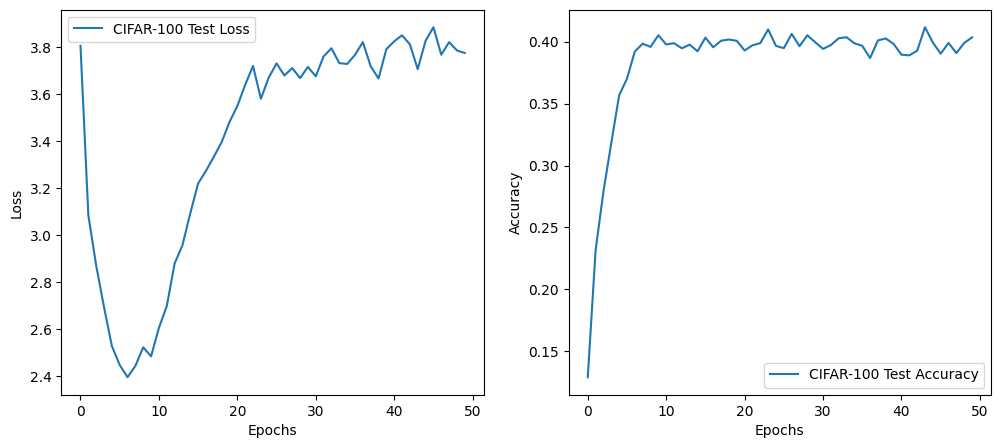

In [74]:
BATCH_SIZE = 96
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
EPOCHS = 50

train_dataset_big = CIFAR100Dataset(DIR_DATA, split='train')
test_dataset = CIFAR100Dataset(DIR_DATA, split='test')

indexes = range(0, len(train_dataset_big))
splitting = train_test_split(indexes, train_size = 0.8, random_state = 42, stratify = train_dataset_big.data["label"], shuffle = True)
train_indexes = splitting[0]
val_indexes = splitting[1]

train_dataset = Subset(train_dataset_big, train_indexes)
val_dataset = Subset(train_dataset_big, val_indexes)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model_cifar = models.resnet18(pretrained=False, num_classes=100)


optimizer_cifar = optim.SGD(model_cifar.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

scheduler_cifar = CosineAnnealingLR(optimizer_cifar, T_max=200)

criterion = nn.CrossEntropyLoss()


train_losses_cifar, test_losses_cifar, test_accuracies_cifar = train_model(
    model=model_cifar,
    train_loader = train_dataloader,
    test_loader = test_dataloader,
    optimizer=optimizer_cifar,
    scheduler=scheduler_cifar,
    criterion=criterion,
    epochs=50
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(test_losses_cifar, label='CIFAR-100 Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_cifar, label='CIFAR-100 Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()